In [1]:
%load_ext autoreload
%autoreload 2
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import fastcat.fastcat as fc
import glob

In [6]:
spectra = ['Al_spectrum_6',
           'W_spectrum_6']
scats = []

angles = np.linspace(0,np.pi*2,2)        
phantom = fc.Catphan_515()
s = fc.Spectrum()

for spectrum in spectra:

    s.load(spectrum)
    kernel = fc.Kernel(s, 'CuGOS-784-micrometer')
    scats.append(np.mean(phantom.return_projs(kernel,s,angles,det_on=False,mgy = 0.0)[0],0))

(19, 41, 41) 19
(19, 41, 41) 19


In [7]:
real_spec = np.load('data/w_spec_profile.npy')
real_spec_CT = np.load('/home/xcite/scintillators/Catphan_dose/batch_submission_W/analysis/Readout_0000.phsp.npy')

<IPython.core.display.Javascript object>


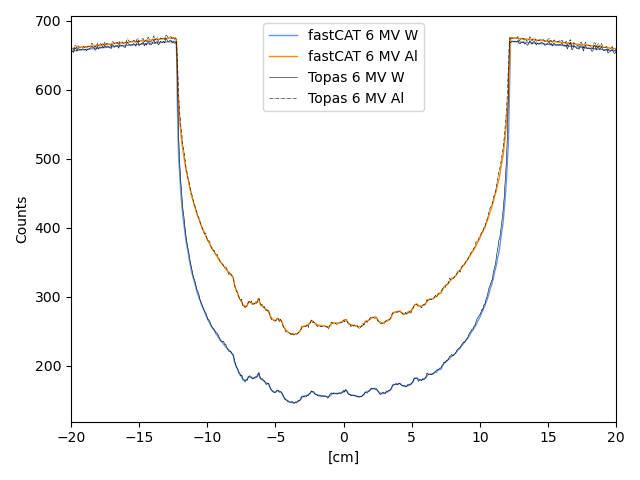

In [8]:
plt.figure()
plt.subplot(111)

dist = np.linspace(-256*0.0784 - 0.0392,256*0.0784 - 0.0392, 512)

# The primary projection don't include any scatter should add the coherent and the incoherent scatter
plt.plot(dist,scats[0],linewidth = 1.0,color = 'cornflowerblue')
plt.plot(dist,scats[1],linewidth = 1.0,color = 'darkorange')

plt.plot(dist,real_spec,'k-',linewidth = 0.4)
plt.plot(dist,np.mean(real_spec_CT,0),'k-.',linewidth = 0.4,markersize=0.4)
plt.xlim([-20,20])

plt.legend(['fastCAT 6 MV W', 'fastCAT 6 MV Al','Topas 6 MV W', 'Topas 6 MV Al'])
plt.xlabel('[cm]')
plt.ylabel('Counts')
plt.tight_layout()

# I'll do the same thing for the 404 phantom

In [3]:
spectra = ['W_spectrum_6']
MV_detectors = ['CuGOS-784-micrometer']
scats = []

angles = np.linspace(np.pi/2,np.pi*2,2)        
phantom = fc.Catphan_404()
s = fc.Spectrum()

for spectrum in spectra:

    s.load(spectrum)
    kernel = fc.Kernel(s, MV_detectors[0])
    scats.append(np.mean(phantom.return_projs(kernel,s,angles,det_on=False,mgy = 0.0)[0],0))

(19, 41, 41) 19


In [4]:
real_spec_CT = np.load('/home/xcite/scintillators/MV_CBCT_exp/analysis/2020-11-18-h14m02/composite.npy')

<IPython.core.display.Javascript object>


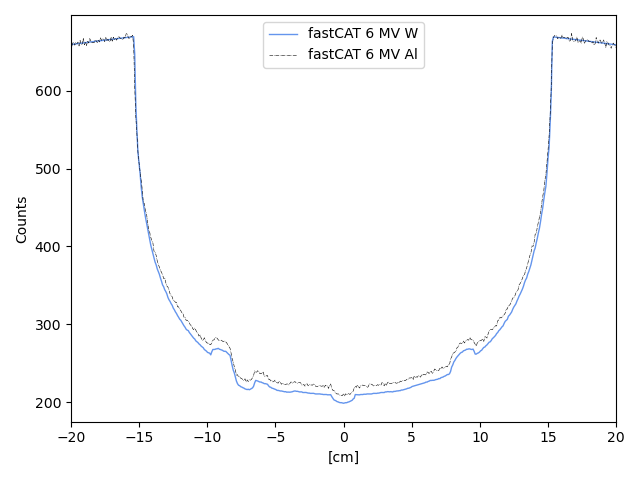

In [5]:
plt.figure()
plt.subplot(111)

dist = np.linspace(-256*0.0784 - 0.0392,256*0.0784 - 0.0392, 512)

# The primary projection don't include any scatter should add the coherent and the incoherent scatter
plt.plot(dist,scats[0][-1::-1],linewidth = 1.0,color = 'cornflowerblue')

plt.plot(dist,np.mean(real_spec_CT,0),'k-.',linewidth = 0.4,markersize=0.4)
plt.xlim([-20,20])

plt.legend(['fastCAT 6 MV W', 'fastCAT 6 MV Al','Topas 6 MV W', 'Topas 6 MV Al'])
plt.xlabel('[cm]')
plt.ylabel('Counts')
plt.tight_layout()

# Now looking at the full thing

In [25]:
spectra = ['W_spectrum_6']
MV_detectors = ['CuGOS-784-micrometer']
scats = []

angles = np.linspace(np.pi/2,np.pi*2,2)      
# angles = np.linspace(0,np.pi*2,2)        

phantom = fc.Catphan_404()
s = fc.Spectrum()

for spectrum in spectra:

    s.load(spectrum)
    kernel = fc.Kernel(s, MV_detectors[0])
    scats.append(np.mean(phantom.return_projs(kernel,s,angles,mgy = 0.0,test=2)[0],0))

(19, 41, 41) 19
really doing it!
ratio is None number of photons 5027.974832879067


In [26]:
real_spec_CT = np.load('/home/xcite/scintillators/MV_CBCT_exp/Catphan_404_w_det.npy')
Catphan2 = np.load('/home/xcite/MV_CBCT/projections/Catphan2.npy')
Air = np.load('/home/xcite/MV_CBCT/projections/air.npy')

<IPython.core.display.Javascript object>


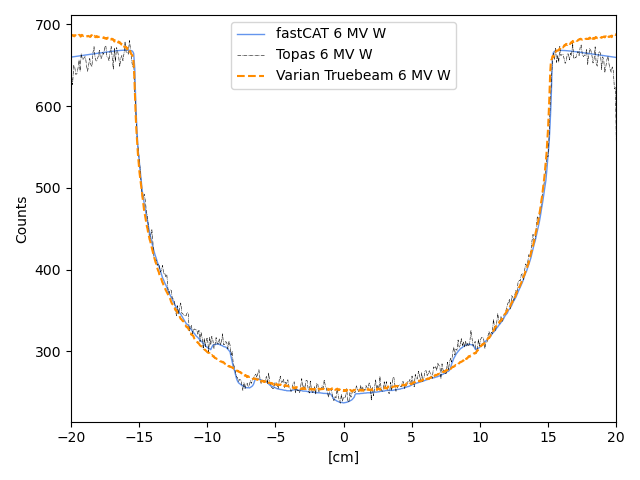

In [29]:
plt.figure()
plt.subplot(111)

dist = np.linspace(-256*0.0784 - 0.0392,256*0.0784 - 0.0392, 512)
dist_long = np.linspace(-256*0.0784 - 0.0392,256*0.0784 - 0.0392, 1024)

# The primary projection don't include any scatter should add the coherent and the incoherent scatter
plt.plot(dist,(scats[0][-1::-1]),linewidth = 1.0,color = 'cornflowerblue')

plt.plot(dist,14.25*real_spec_CT,'k-.',linewidth = 0.4,markersize=0.4)
plt.xlim([-20,20])
# plt.plot(dist_long,(np.mean(Air[63,200:220],0)/3)[-1::-1],'-',linewidth = 1,color = 'darkorange')
plt.plot(dist_long,(np.mean(Catphan2[63,200:220],0)/3)[-1::-1],'--',linewidth = 1.5,color = 'darkorange')
plt.legend(['fastCAT 6 MV W', 'Topas 6 MV W','Varian Truebeam 6 MV W', 'Topas 6 MV Al'])
plt.xlabel('[cm]')
plt.ylabel('Counts')
plt.tight_layout()

In [304]:
plt.savefig('/home/xcite/fastcat_paper/figures/one_slice_comparison.pdf')

<IPython.core.display.Javascript object>


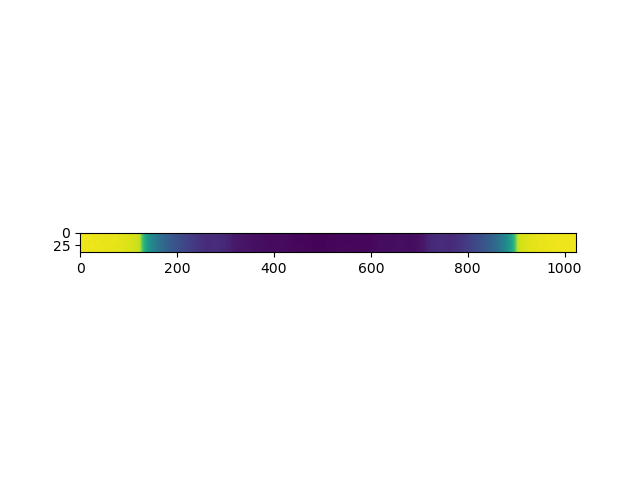

In [700]:
plt.figure()
plt.imshow(Catphan2[63,260:300])

<IPython.core.display.Javascript object>


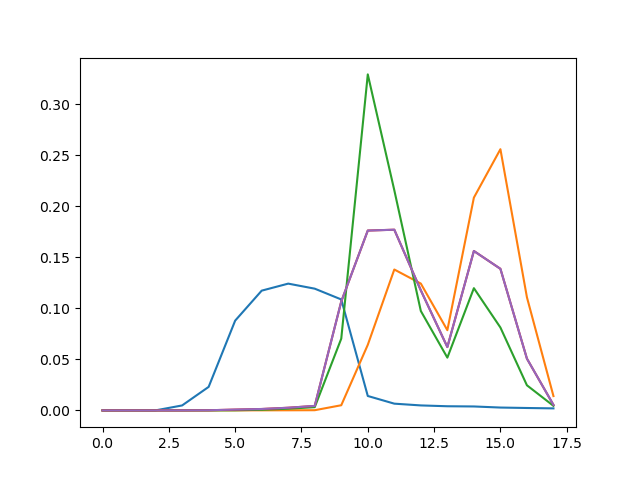

In [363]:
plt.figure()
dep_eff = [0.00000000e+00, 0.00000000e+00, 3.71873657e-05, 4.85904579e-03,
       2.30410791e-02, 8.79657308e-02, 1.17341364e-01, 1.24223022e-01,
       1.19282628e-01, 1.08713848e-01, 1.41254215e-02, 6.60505371e-03,
       4.87490513e-03, 4.06587348e-03, 3.85836743e-03, 2.79186279e-03,
       2.35730273e-03, 1.98059733e-03]
plt.plot(dep_eff)
plt.plot(weights_woutdet)
plt.plot(weights_woutdet2)
plt.plot(weights_wdet)
plt.plot((weights_woutdet*dep_eff)/np.sum((weights_woutdet*dep_eff)))

In [362]:
weights_woutdet2 = phantom.weights_small

(19, 41, 41) 19
[0.00000000e+00 1.97676735e-04 4.59538275e-03 1.87763403e-02
 2.69218011e-02 2.19212151e-02 2.16033405e-02 2.61904166e-02
 3.32862718e-02 3.19644957e-02 2.81112167e-02 3.27392041e-02
 3.49504830e-02 3.46741088e-02 3.36192686e-02 3.02069999e-02
 2.63395066e-02 2.97071624e-02 2.38111659e-02 2.25007260e-02
 2.10556003e-02 1.95742454e-02 1.83324695e-02 1.69440891e-02
 1.62341136e-02 1.54300915e-02 1.46698057e-02 1.35275988e-02
 1.28700969e-02 1.21599095e-02 1.14506187e-02 1.09809591e-02
 1.05724920e-02 1.01646457e-02 9.76984695e-03 9.44686642e-03
 9.04474348e-03 8.69744479e-03 8.36870305e-03 8.00925220e-03
 7.77000158e-03 7.51854020e-03 7.09571857e-03 7.01812092e-03
 6.65557358e-03 6.37730877e-03 6.17624050e-03 6.03458005e-03
 5.67710643e-03 5.55974435e-03 5.41242980e-03 5.21155994e-03
 5.07713105e-03 4.80127970e-03 4.54499759e-03 4.51834069e-03
 4.30765877e-03 4.12906655e-03 4.05679017e-03 3.96064121e-03
 3.77928558e-03 3.67974928e-03 3.48113359e-03 3.33273164e-03
 3.29799

<IPython.core.display.Javascript object>


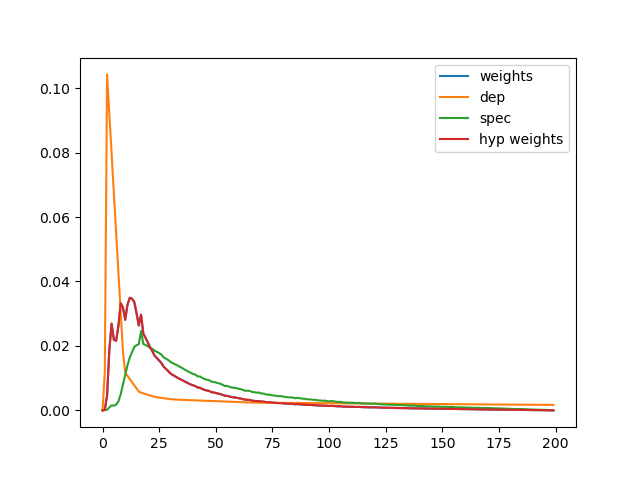

In [149]:
spectra = ['W_spectrum_6']
MV_detectors = ['CuGOS-784-micrometer']
scats = []

angles = np.linspace(np.pi/2,np.pi*2,2)        
phantom = fc.Catphan_404()
s = fc.Spectrum()

for spectrum in spectra:

    s.load(spectrum)
    kernel = fc.Kernel(s, MV_detectors[0])

plt.figure()
plt.plot(kernel.weights/np.sum(kernel.weights),label='weights')
plt.plot(kernel.deposition_interpolated/np.sum(kernel.deposition_interpolated),label='dep')
plt.plot(kernel.fluence,label='spec')
ww = kernel.fluence*kernel.deposition_interpolated
plt.plot(ww/np.sum(ww),label='hyp weights')
plt.legend()

<IPython.core.display.Javascript object>


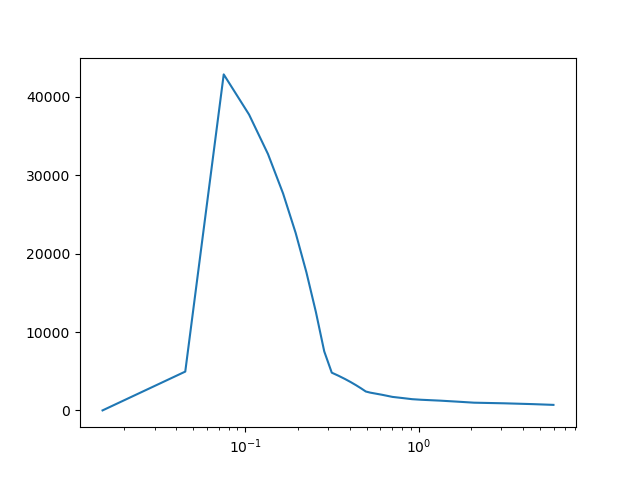

In [153]:
plt.figure()
plt.semilogx(s.x/1000,kernel.deposition_interpolated)

In [386]:
dat = np.load('../fastcat/data/scatter/scatter_updated.npy')

In [390]:
dat2 = np.load('/home/xcite/scintillators/MV_CBCT_exp/scatter_edep.npy')

<IPython.core.display.Javascript object>


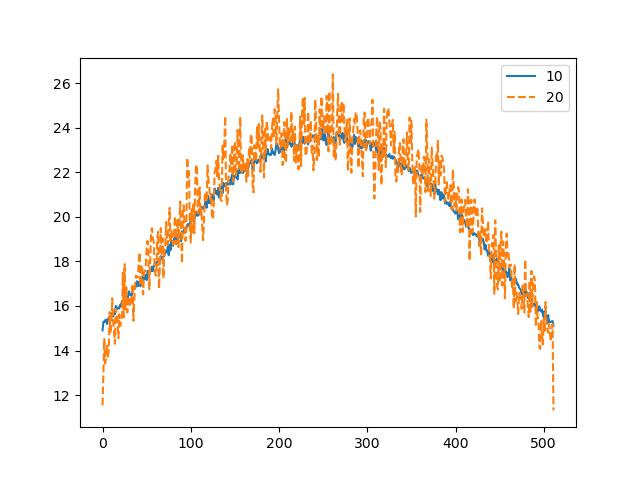

In [628]:
plt.figure()
plt.plot(dat@phantom.weights_small,'-')
plt.plot(16.5*np.sum(dat2.T,1),'--')
plt.legend(original_energies_keV)

<IPython.core.display.Javascript object>


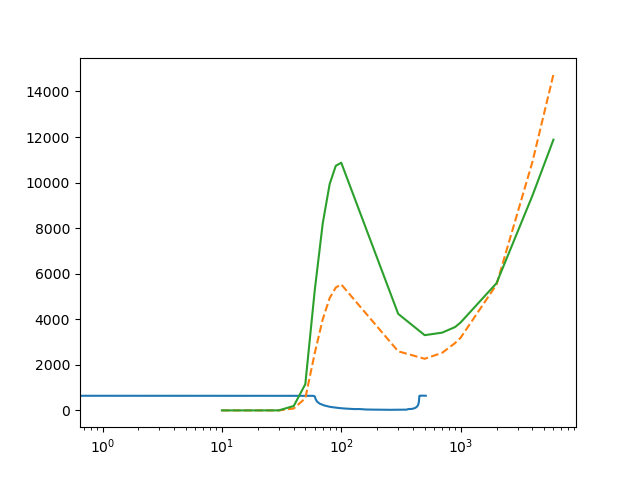

In [578]:
dat3 = np.load('/home/xcite/scintillators/MV_CBCT_exp/primary_edep.npy')

# nw = phantom.weights_small*(phantom.deposition_summed/original_energies_keV)
# nw /= np.sum(nw)
plt.figure()
plt.plot((np.array(phantom.projections).T@phantom.weights_small),'-')
plt.plot((np.array(phantom.projections).T@phantom.weights_small),'-')

plt.semilogx(original_energies_keV,10*np.sum(dat3.T,0),'--')
plt.semilogx(original_energies_keV,phantom.deposition_summed*(original_energies_keV/1000)*1000000)

In [579]:
from scipy.optimize import minimize_scalar

In [611]:
res = []

for ii in range(18):
    a = dat3.T[:,ii]
    b = (np.array(phantom.projections).T*phantom.weights_small*phantom.deposition_summed*original_energies_keV/2000)[:,ii]
    res.append(minimize_scalar(min_fun,args=(a,b)).x)

In [612]:
def min_fun(x,a,b):
    
    return(np.std(x*a - b))

/home/xcite/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


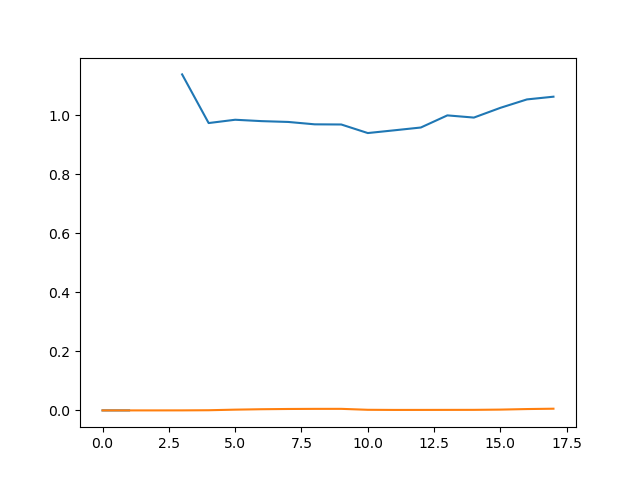

In [613]:
c = phantom.weights_small/res

plt.figure()
plt.plot(c)
plt.plot(phantom.deposition_summed*original_energies_keV/2070)

/home/xcite/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


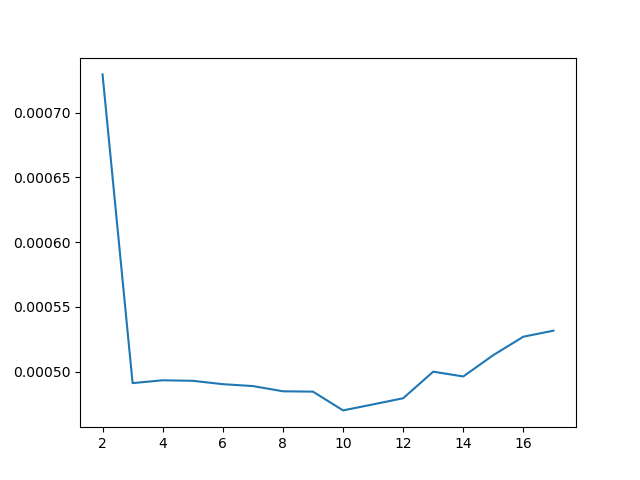

In [562]:
c = (phantom.weights_small)/(res*phantom.deposition_summed*original_energies_keV)

plt.figure()
plt.plot(c)
# plt.plot(phantom.deposition_summed*original_energies_keV/2000)

<IPython.core.display.Javascript object>


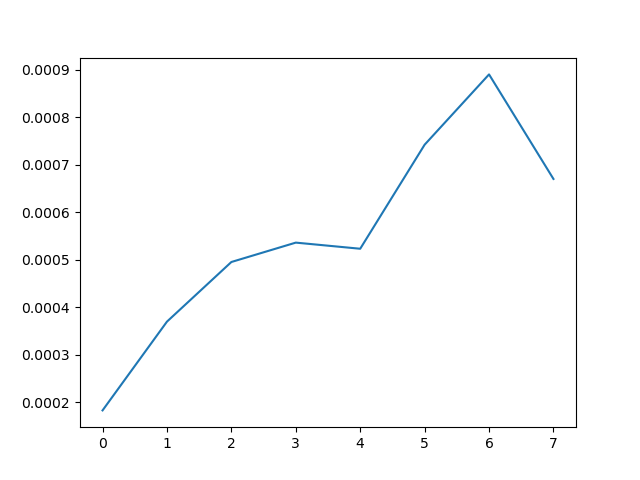

/home/xcite/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [525]:
plt.figure()
plt.plot((c/(phantom.deposition_summed*(original_energies_keV/1000)))[10:])

<IPython.core.display.Javascript object>


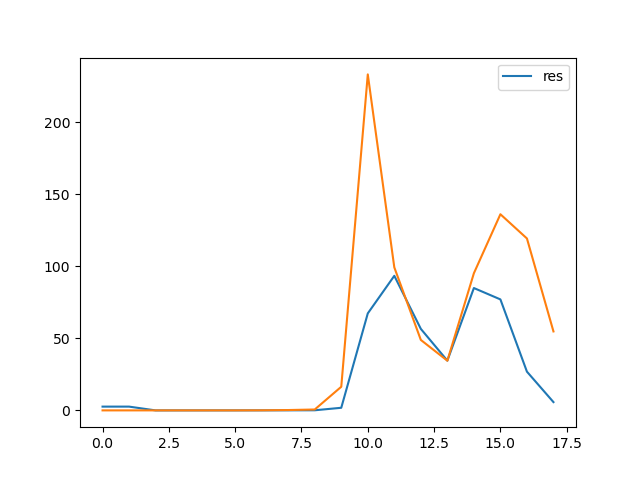

In [506]:
plt.figure()
plt.plot(res,label='res')
plt.plot(16000*phantom.weights_small*(phantom.deposition_summed*original_energies_keV/100))
plt.legend()

<IPython.core.display.Javascript object>


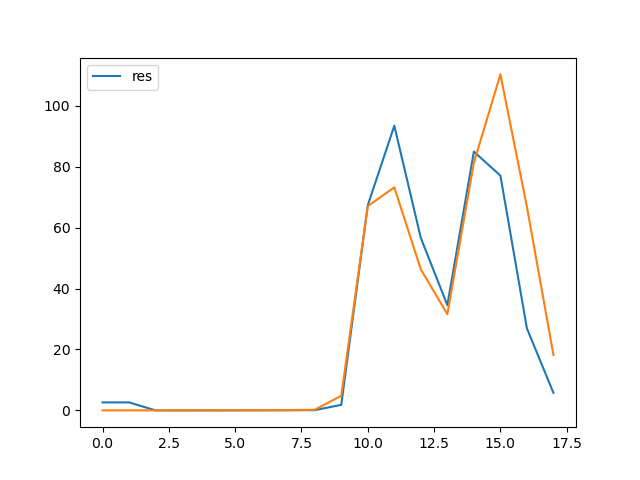

In [491]:
plt.figure()
plt.plot(res,label='res')
plt.plot(500*phantom.weights_small)
plt.legend()

<IPython.core.display.Javascript object>


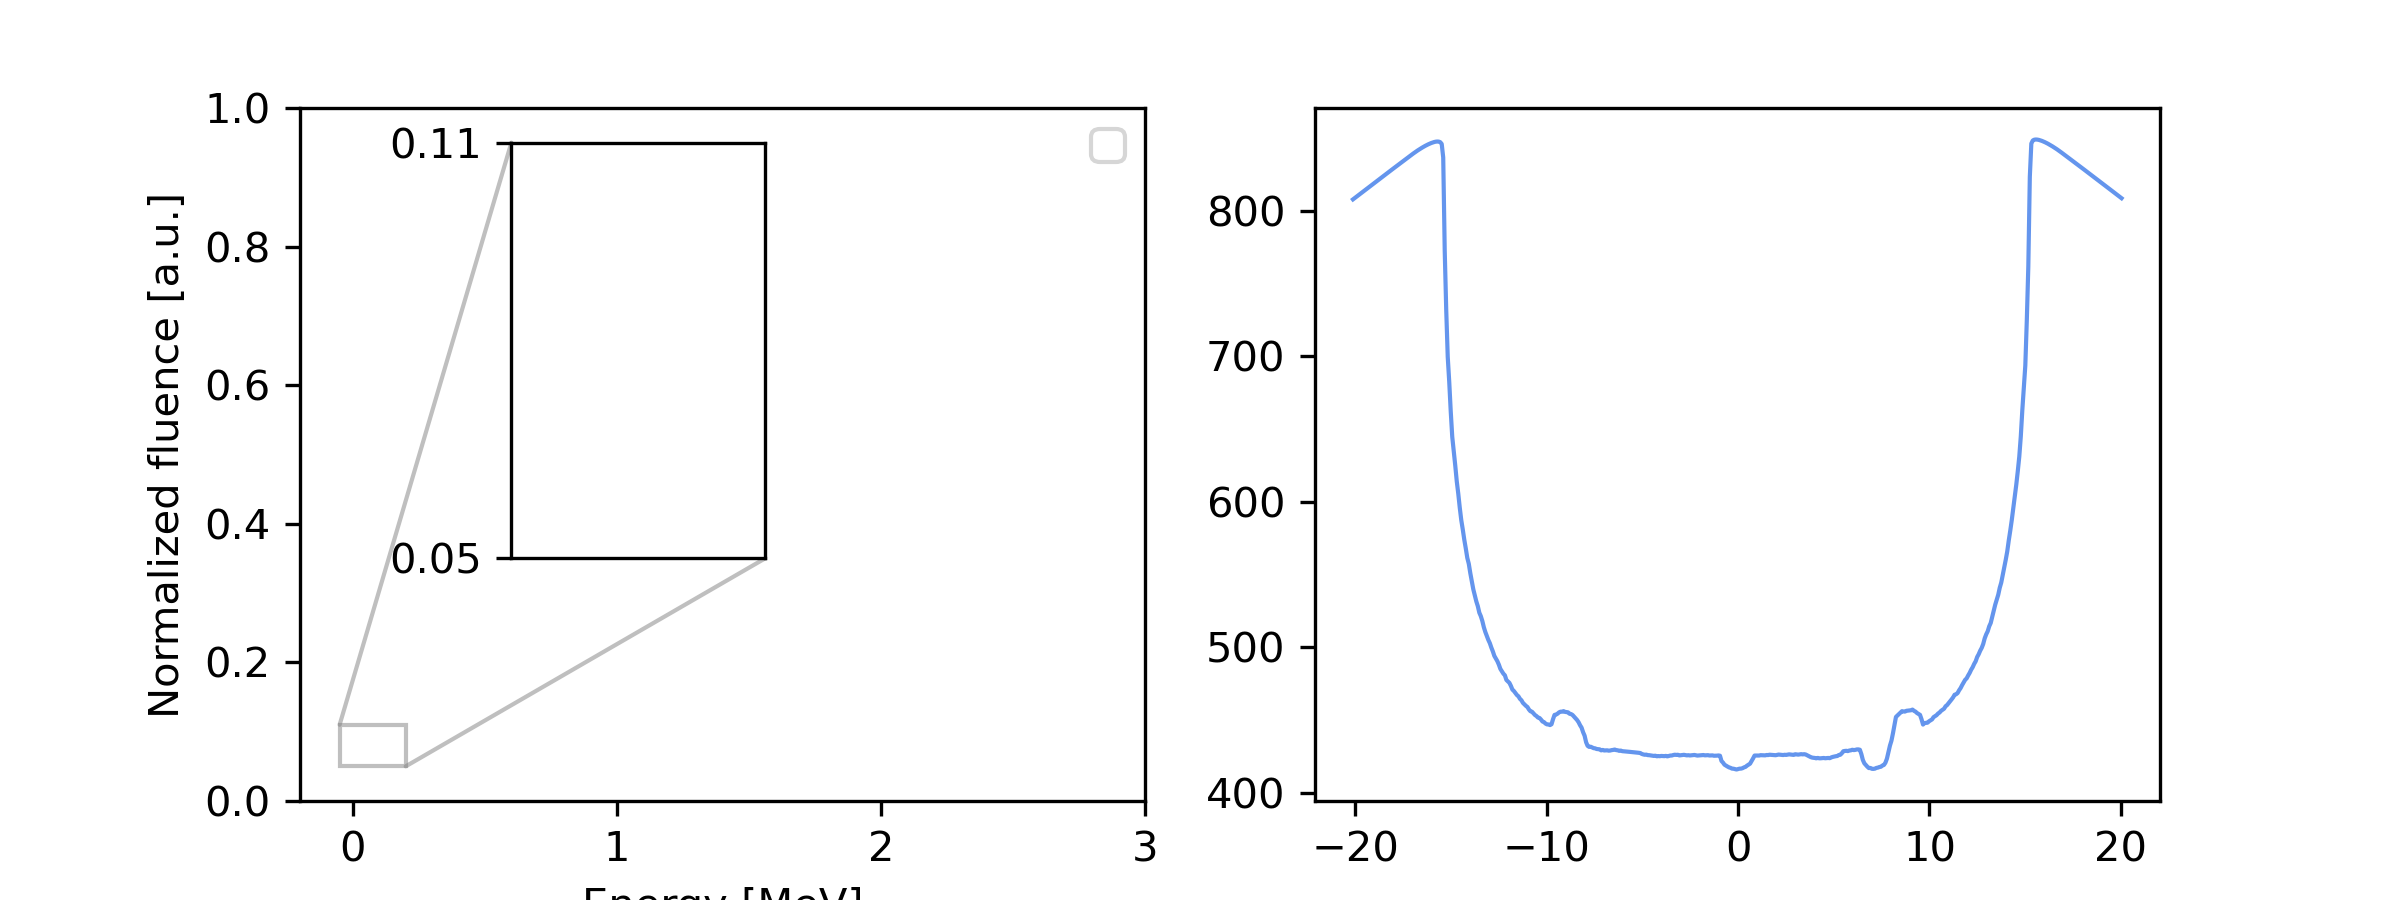

IndexError: list index out of range

In [303]:
# plt.figure()
# plt.plot(-np.log(mc_noise/flood_summed2))

# plt.figure(dpi=300,figsize=[8,4])
# plt.subplot(121)

files = glob.glob('../xpecgen/data/MV_spectra/*.txt')

fig,ax = plt.subplots(1,2,figsize=[8,3],dpi=300)
names = []

fmt_spec = ['-', ':', '-', ':','-', ':', '-', ':']
colors = ['cornflowerblue','cornflowerblue','darkorange','darkorange','k','k',]

ax2 = ax[0].inset_axes([0.25, 0.35, 0.3, 0.6])
# axin2 = ax.inset_axes(
#         [-0.1, 0.04, 0.4, 0.08], transform=ax.transData)
# axin2.set_xticks([])
# axin2.set_yticks([])

for jj,file in enumerate(sorted(files)):
    
    fluence = []
    energies = []
    
    names.append(file.split('_'))

    with open(file) as f:

        for line in f:
            energies.append(float(line.split()[0]))
            fluence.append(float(line.split()[1]))

    fluence /= np.sum(fluence)
    
    ax[0].plot(energies,fluence,fmt_spec[jj],color=colors[jj])
    ax2.plot(energies,fluence,fmt_spec[jj],color=colors[jj])


    fluence_str = [str(fluenc) for fluenc in fluence]
    energies = [str(energy) for energy in energies]
    with open(file.split('.txt')[0] + 'topas','w') as out:
        out.write(file + '\n \n')
        out.write('dv:So/Example/BeamEnergySpectrumValues = ' + str(len(energies)) +' ' + ' '.join(energies) + '\n')
        out.write('uv:So/Example/BeamEnergySpectrumWeights = ' + str(len(energies)) + ' ' + ' '.join(fluence_str) + '\n \n')
        
labels = []

for ii in range(len(names)):
    
    labels.append(names[ii][1].split('/')[1] + ' 6 MV' if ii % 2 == 1 else names[ii][1].split('/')[1] + ' 2.5 MV')
    
ax[0].legend(labels)
ax[0].set_xlim([-0.2,3])
ax[0].set_xlabel('Energy [MeV]')
ax[0].set_ylabel('Normalized fluence [a.u.]')


ax2.set_xlim([-0.05,0.2])
ax2.set_ylim([0.05,0.11])
ax2.set_xticks([])
ax2.set_yticks([0.05,0.11])

ax[0].indicate_inset_zoom(ax2)

# plt.subplot(122)
# plt.plot(2*mc_noise)

# The primary projection don't include any scatter should add the coherent and the incoherent scatter
ax[1].plot(dist,scats[0],linewidth = 1.0,color = 'cornflowerblue')
ax[1].plot(dist,scats[1],linewidth = 1.0,color = 'darkorange')

# plt.plot(fc_prime_2 + 3*mc_scatter - 2*coh_scatter,'r',linewidth= 0.7)
# plt.plot(fc_prime_2)
# plt.plot(flood_summed2)
ax[1].plot(dist,real_spec,'k-',linewidth = 0.4)
ax[1].plot(dist,np.mean(real_spec_CT,0),'k-.',linewidth = 0.4,markersize=0.4)
ax[1].set_xlim([-20,20])
# plt.plot(dist,real_spec_water_2,'k--',linewidth = 0.7)
# plt.plot(real_spec_water_3*2,'k--',linewidth = 0.7)

ax[1].legend(['fastCAT 6 MV W','fastCAT 6 MV Al','Topas 6 MV W','Topas 6 MV Al'])
ax[1].set_xlabel('[cm]')
ax[1].set_ylabel('Counts')
plt.tight_layout()
# plt.plot(real_spec_water,'k',linewidth= 0.7)
# plt.plot(fc_prime_2 + 2*mc_scatter_e,'r')
# plt.plot(2*mc_noise,'g')
# plt.plot(fc_prime_2,'.')